In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [2]:
dfb1 = pd.read_csv('Data/Building Data/Building 1.csv')

In [3]:
dfb1

,Unnamed: 0,series_value,datetime,Year,Month,Day_of_Month,Hour,minutes,series_name
0,3,32.7,2019-01-10 00:00:00,2019,1,10,0,0,Building1
1,7,34.5,2019-01-10 01:00:00,2019,1,10,1,0,Building1
2,11,32.5,2019-01-10 02:00:00,2019,1,10,2,0,Building1
3,15,33.0,2019-01-10 03:00:00,2019,1,10,3,0,Building1
4,19,38.6,2019-01-10 04:00:00,2019,1,10,4,0,Building1
...,...,...,...,...,...,...,...,...,...
15836,63439,10.6,2020-10-31 19:00:00,2020,10,31,19,0,Building1
15837,63443,9.9,2020-10-31 20:00:00,2020,10,31,20,0,Building1
15838,63447,10.8,2020-10-31 21:00:00,2020,10,31,21,0,Building1
15839,63451,9.8,2020-10-31 22:00:00,2020,10,31,22,0,Building1


In [4]:
data = dfb1['series_value'][15500:15800]

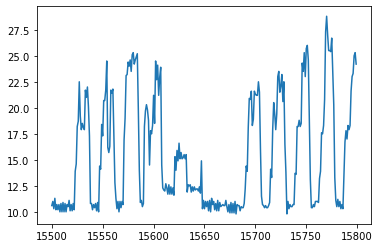

In [5]:
plt.plot(data)

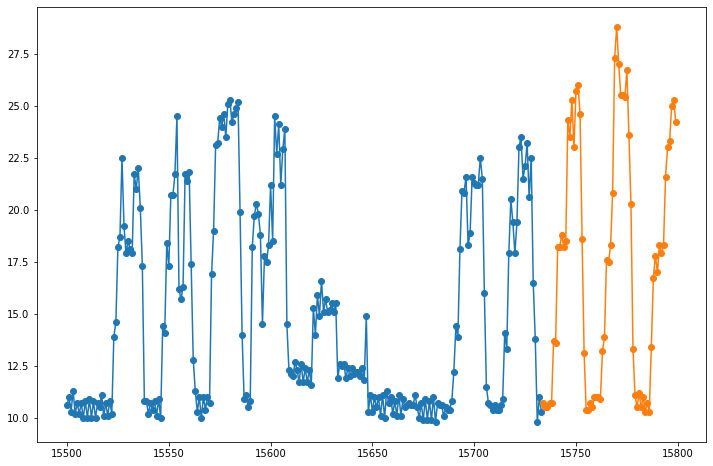

In [6]:
train_size = 0.78

ts = data

split_idx = round(len(data)* train_size)

# Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)

In [7]:
modelactual = auto_arima(train, start_p=0, start_q=0, seasonal=True)
modelactual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -505.604
Date:                Tue, 27 Sep 2022   AIC                           1017.208
Time:                        22:20:49   BIC                           1027.574
Sample:                             0   HQIC                          1021.388
                                - 234                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4590      0.658      2.219      0.026       0.170       2.748
ar.L1          0.8993      0.037     24.201      0.000       0.826       0.972
sigma2         4.3774      0.338     12.932      0.000       3.714       5.041
===================================================================================
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                62.94
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.13
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [9]:
data = train
# define model
my_order = (1, 1, 0)
my_seasonal_order = (1, 1, 0, 24)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit = model.fit()
# one step forecast
yhat = model_fit.predict(end=len(test))

In [10]:
yhat

15500     0.000000
15501    10.599997
15502    11.000000
15503    10.300000
15504    11.299999
           ...    
15562    13.686537
15563    13.161254
15564    11.026409
15565    10.891884
15566    10.377306
Name: predicted_mean, Length: 67, dtype: float64

In [11]:
lst = []
for i in range(15501, 15566):
    lst.append(yhat[i])

In [12]:
forecastdf = pd.DataFrame(lst, columns=['forecast']) 

In [13]:
test

15734    10.7
15735    10.5
15736    10.5
15737    10.7
15738    10.7
         ... 
15795    23.0
15796    23.3
15797    25.0
15798    25.3
15799    24.2
Name: series_value, Length: 66, dtype: float64

In [14]:
lst = []
for i in range(15734, 15800):
    lst.append(test[i])

In [15]:
testdfnew = pd.DataFrame(lst, columns=['test']) 

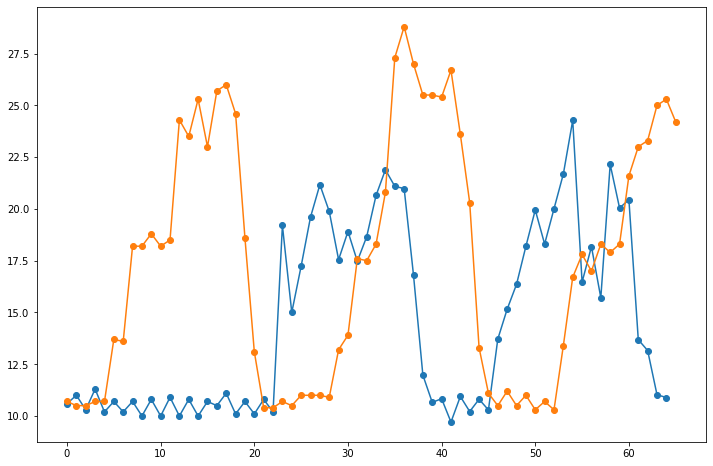

In [16]:
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(forecastdf['forecast'], label='Forecast', **kws)
plt.plot(testdfnew['test'], label='Test', **kws)

In [17]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))


pred = forecastdf['forecast'] 
tst = testdfnew['test']
trn = train

mean_absolute_scaled_error(pred,tst,trn)

4.969486406812728